In [4]:
import os
import pandas as pd
import gzip
import json
import numpy as np

In [2]:
path = os.getcwd()
print(path)

/Users/gajdulj/Dev/NLP


In [3]:
os.listdir()

['.DS_Store',
 'amazon_nlp.ipynb',
 'data.csv',
 'Kindle_Store_5.json.gz',
 '.gitignore',
 '.ipynb_checkpoints']

In [4]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Kindle_Store_5.json.gz')

In [5]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,True,"07 3, 2014",A2LSKD2H9U8N0J,B000FA5KK0,{'Format:': ' Kindle Edition'},sandra sue marsolek,"pretty good story, a little exaggerated, but I...",pretty good story,1404345600,NaN,NaN
1,5.0,True,"05 26, 2014",A2QP13XTJND1QS,B000FA5KK0,{'Format:': ' Kindle Edition'},Tpl,"If you've read other max brand westerns, you k...",A very good book,1401062400,NaN,NaN
2,5.0,True,"09 16, 2016",A8WQ7MAG3HFOZ,B000FA5KK0,{'Format:': ' Kindle Edition'},Alverne F. Anderson,"Love Max, always a fun twist",Five Stars,1473984000,NaN,NaN
3,5.0,True,"03 3, 2016",A1E0MODSRYP7O,B000FA5KK0,{'Format:': ' Kindle Edition'},Jeff,"As usual for him, a good book",a good,1456963200,NaN,NaN
4,5.0,True,"09 10, 2015",AYUTCGVSM1H7T,B000FA5KK0,{'Format:': ' Kindle Edition'},DEHS - EddyRapcon,MB is one of the original western writers and ...,A Western,1441843200,2,NaN


In [6]:
# Check for blanks
df.isna().sum()

overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
style               52617
reviewerName          127
reviewText            403
summary              1755
unixReviewTime          0
vote              1931032
image             2221618
dtype: int64

In [7]:
df['verified'].value_counts()

True     1418037
False     804946
Name: verified, dtype: int64

In [8]:
# Keep only verified reviewers
df=df.loc[df['verified'] == True]

In [9]:
df['verified'].value_counts()

True    1418037
Name: verified, dtype: int64

In [10]:
# Select relevant columns
relevant_columns=['reviewText','overall']
df = df[relevant_columns]

In [11]:
# Drop neutral reviews
df=df.loc[df['overall']!= 3]

In [12]:
df['overall'].value_counts()

5.0    862434
4.0    334611
2.0     49397
1.0     36293
Name: overall, dtype: int64

In [13]:
# Create a binary column to indicate if review is positive or not
df['positive']=df['overall'].apply(lambda x: 1 if x >3 else 0)

In [14]:
df.head(5)

,reviewText,overall,positive
0,"pretty good story, a little exaggerated, but I...",4.0,1
1,"If you've read other max brand westerns, you k...",5.0,1
2,"Love Max, always a fun twist",5.0,1
3,"As usual for him, a good book",5.0,1
4,MB is one of the original western writers and ...,5.0,1


In [5]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
def clean_text(raw_text):

    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text) 

    # Convert to lower case, split into individual words
    words = letters_only.lower().split()                                             

    # Remove stop words
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops]   
    
    # Join the words back into one string separated by space
    clean_text=(" ".join(meaningful_words)) 
    
    return clean_text

In [17]:
# Convert to string
df['reviewText']=df['reviewText'].apply(str)

In [19]:
df['clean_text']=df['reviewText'].apply(lambda x: clean_text(x))

In [20]:
df.head()

,reviewText,overall,positive,clean_text
0,"pretty good story, a little exaggerated, but I...",4.0,1,pretty good story little exaggerated liked pre...
1,"If you've read other max brand westerns, you k...",5.0,1,read max brand westerns know expect treat let ...
2,"Love Max, always a fun twist",5.0,1,love max always fun twist
3,"As usual for him, a good book",5.0,1,usual good book
4,MB is one of the original western writers and ...,5.0,1,mb one original western writers many years man...


In [21]:
# kernel was crashing at train/test split.
# save the new table to avoid running the whole preprocessing again

In [22]:
df.to_csv('/Users/gajdulj/Dev/NLP/data.csv')

In [6]:
df = pd.read_csv('/Users/gajdulj/Dev/NLP/data.csv')

In [7]:
# Get rid of empty reviews
df = df[df['clean_text'].notnull()]

In [8]:
text_list = df['clean_text'].tolist()

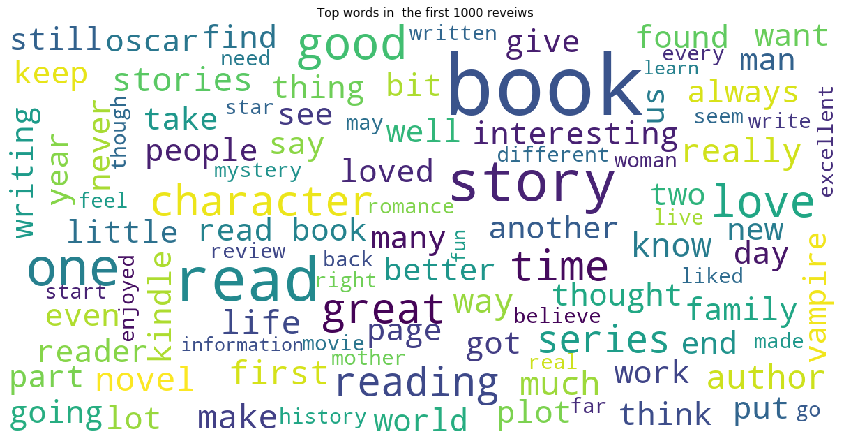

In [48]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    text = " ".join(review for review in data[:1000])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=40, 
        scale=3,
        random_state=1
).generate(text)

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        plt.title(title)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(text_list, title='Top words in  the first 1000 reveiws')

In [159]:
print ("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 6000) 

# The input to fit_transform should be a list of strings.
train_data_features = vectorizer.fit_transform(text_list)

print ("Done")

Creating the bag of words...

Done


In [161]:
# limit data to first 10k, otherwise kernel crashed
train_data_features = train_data_features[:50000]

In [162]:
train_data_features.shape[0]

50000

In [163]:
labels = df['positive'][:50000]

In [164]:
#splitting dataset into training and testing data
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(
    train_data_features,labels,
    test_size=0.2,random_state=42, stratify=None, shuffle=False)

print("Splitting Done")

Splitting Done


In [165]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 10, 
            max_depth=100, max_features=1000, 
            n_jobs=4, verbose=1) 

In [167]:
forest = forest.fit(X_train, Y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    7.6s finished


In [168]:
# Use the random forest to make sentiment label predictions
result = forest.predict(X_test)
print("Predictions Done")

Predictions Done


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished


In [169]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
#checking accuracy score
accuracy=accuracy_score(Y_test,result)
accuracy

0.9111

In [170]:
#checking f1 score
f1=f1_score(Y_test,result)
f1

0.9517398621138918

In [171]:
# Check feature importance
importances = forest.feature_importances_

In [172]:
# Get a list of feature names
feature_names = vectorizer.get_feature_names()

In [173]:
assert(len(feature_names)==len(importances))

In [174]:
importances = list(importances)

In [175]:
features_scored = zip(feature_names,importances)

In [176]:
import operator
sorted_features_scored = sorted(features_scored, key = operator.itemgetter(1),reverse=True) 

In [178]:
sorted_features_scored[:5]

[('waste', 0.04059738068295893),
 ('boring', 0.025843233936374332),
 ('great', 0.014158418961296524),
 ('enjoyed', 0.011748145204804574),
 ('finish', 0.01131223861001429)]